In [2]:
%%writefile requirements.txt
langchain==0.1.14
pypdf==4.1.0
faiss-cpu==1.8.0
boto3==1.34.58
sqlalchemy==2.0.29

Overwriting requirements.txt


In [3]:
import sqlalchemy
print(sqlalchemy.__version__)

2.0.29


In [5]:
!pip install -U -r requirements.txt

In [10]:
pip install nvidia-ml-py3==7.352.0

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install sqlparse==0.5.0

  Using cached sqlparse-0.5.0-py3-none-any.whl.metadata (3.9 kB)
Using cached sqlparse-0.5.0-py3-none-any.whl (43 kB)
  Attempting uninstall: sqlparse
    Found existing installation: sqlparse 0.5.1
    Uninstalling sqlparse-0.5.1:
      Successfully uninstalled sqlparse-0.5.1
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install scikit-learn==1.3.0

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install omegaconf==2.2.3

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install gluonts==0.15.1

  Using cached gluonts-0.15.1-py3-none-any.whl.metadata (9.9 kB)
Using cached gluonts-0.15.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.14.3
    Uninstalling gluonts-0.14.3:
      Successfully uninstalled gluonts-0.14.3
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install langchain==0.1.14

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install boto3==1.34.58

Note: you may need to restart the kernel to use updated packages.


In [16]:
import langchain
print(langchain.__version__)

0.1.14


In [17]:
try:
    import sagemaker
except ImportError:
    !pip install sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [18]:
# Import the JumpStartModel class from the SageMaker JumpStart library
from sagemaker.jumpstart.model import JumpStartModel

In [10]:
# Specify the model ID for the HuggingFace Llama 3 8b Instruct LLM model
model_id = "meta-textgeneration-llama-3-8b-instruct"
accept_eula = True
model = JumpStartModel(model_id=model_id, model_version="2.7.0", instance_type= "ml.g5.2xlarge")

In [11]:
predictor = model.deploy(accept_eula=accept_eula, instance_type="ml.g5.2xlarge")

-----------------!

In [12]:
# Specify the model ID for the HuggingFace BGE Large EN Embedding model
model_id = "huggingface-sentencesimilarity-bge-large-en-v1-5"
text_embedding_model = JumpStartModel(model_id=model_id,model_version="1.1.1")

In [13]:
embedding_predictor = text_embedding_model.deploy(instance_type="ml.g5.2xlarge")

---------!

In [29]:
import json
import sagemaker

from langchain_core.prompts import PromptTemplate
from langchain_community.llms import SagemakerEndpoint
from langchain_community.embeddings import SagemakerEndpointEmbeddings
from langchain_community.llms.sagemaker_endpoint import LLMContentHandler
from langchain_community.embeddings.sagemaker_endpoint import EmbeddingsContentHandler

In [20]:
sess = sagemaker.session.Session()
region = sess._region_name

In [21]:
llm_endpoint_name = "meta-textgeneration-llama-3-8b-instruct-2024-11-02-18-14-47-703"
embedding_endpoint_name = "hf-sentencesimilarity-bge-large-en-v1-5-2024-11-02-18-26-17-888"

In [23]:
# testing out my endpoint
import boto3
runtime_client = boto3.client('sagemaker-runtime', region_name=region)

input_prompt = {
    "inputs": "What are some common ingredients of ice cream?"
}

response = runtime_client.invoke_endpoint(
    EndpointName=llm_endpoint_name,
    ContentType='application/json',
    Body=json.dumps(input_prompt)
)

In [24]:
# read and print the output
output = json.loads(response['Body'].read().decode())
print("LLM Response:", output)

LLM Response: {'generated_text': ' Ice cream typically consists of a combination of the following ingredients:\n1. Cream: Heavy cream, light cream, or a combination of both are used to'}


In [25]:
from typing import Dict

class Llama38BContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: dict) -> bytes:
        payload = {
            "inputs": prompt,
            "parameters": {
                "max_new_tokens": 1000,
                "top_p": 0.9,
                "temperature": 0.6,
                "stop": ["<|eot_id|>"],
            },
        }
        input_str = json.dumps(
            payload,
        )
        print(input_str)
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        print(response_json)
        content = response_json["generated_text"].strip()
        return content

In [26]:
# Instantiate the content handler for Llama3-8B
llama_content_handler = Llama38BContentHandler()

# Setup for using the Llama3-8B model with SageMaker Endpoint
llm = SagemakerEndpoint(
     endpoint_name=llm_endpoint_name,
     region_name=region,
     model_kwargs={"max_new_tokens": 2048, "top_p": 0.9, "temperature": 0.7},
     content_handler=llama_content_handler
 )

In [27]:
from typing import List

class BGEContentHandlerV15(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, text_inputs: List[str], model_kwargs: dict) -> bytes:
        """
        Transforms the input into bytes that can be consumed by SageMaker endpoint.
        Args:
            text_inputs (list[str]): A list of input text strings to be processed.
            model_kwargs (Dict): Additional keyword arguments to be passed to the endpoint.
               Possible keys and their descriptions:
               - mode (str): Inference method. Valid modes are 'embedding', 'nn_corpus', and 'nn_train_data'.
               - corpus (str): Corpus for Nearest Neighbor. Required when mode is 'nn_corpus'.
               - top_k (int): Top K for Nearest Neighbor. Required when mode is 'nn_corpus'.
               - queries (list[str]): Queries for Nearest Neighbor. Required when mode is 'nn_corpus' or 'nn_train_data'.
        Returns:
            The transformed bytes input.
        """
        input_str = json.dumps(
            {
                "text_inputs": text_inputs,
                **model_kwargs
            }
        )
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> List[List[float]]:
        """
        Transforms the bytes output from the endpoint into a list of embeddings.
        Args:
            output: The bytes output from SageMaker endpoint.
        Returns:
            The transformed output - list of embeddings
        Note:
            The length of the outer list is the number of input strings.
            The length of the inner lists is the embedding dimension.
        """
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["embedding"]

In [28]:
bge_content_handler = BGEContentHandlerV15()
sagemaker_embeddings = SagemakerEndpointEmbeddings(
    endpoint_name=embedding_endpoint_name,
    region_name=region,
    model_kwargs={"mode": "embedding"},
    content_handler=bge_content_handler,
)

Load CSV files into Embeddings

In [30]:
import os
import pandas as pd
import boto3
import numpy as np
from io import StringIO
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

In [31]:
# Set up s3
s3 = boto3.client('s3')
bucket_name = 'hf-recipedata-csv'

# List all CSV files in the bucket
csv_files = []
response = s3.list_objects_v2(Bucket=bucket_name)

# Filter for CSV files
for obj in response.get('Contents', []):
    if obj['Key'].endswith('.csv'):
        csv_files.append(obj['Key'])

# Load each CSV file into a DataFrame and combine them
dataframes = []
for file_key in csv_files:
    csv_obj = s3.get_object(Bucket=bucket_name, Key=file_key)
    body = csv_obj['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(body))
    dataframes.append(df)

In [32]:
# Concatenate all DataFrames into one DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
print(f"Number of records: {len(combined_df)}")

Number of records: 7446


In [33]:
from langchain.schema import Document
# Initialize an empty list to hold the document chunks
documents = []
texts_from_csv = combined_df['combined_text'].tolist()

# Set a chunk size for splitting documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2048,
    chunk_overlap=102,
)

# Create Document objects and split the loaded text into smaller chunks
document_chunks = text_splitter.split_documents(
    [Document(page_content=text) for text in texts_from_csv]
)

print(document_chunks[5])

page_content='Chocolate Rugelach Allergy: [Flour, Butter, Cream Cheese, Egg, Vanilla, Almond] Cuisine: American Chocolate Rugelach\n2 1/2 cups (325 grams) all-purpose flour, plus more for dusting\n1/4 cup (50 grams) granulated sugar  \n1/2 teaspoon kosher salt  \n1 cup (226 grams) unsalted butter, cubed  and cold\n8 ounces (226 grams) cream cheese, straight from the fridge  \n2 large egg yolks  plus 1 large whole egg\n1 teaspoon vanilla extract  \n1/2 teaspoon almond extract, optional  \n1 1/2 cups (260 grams) chocolate chips or chopped chocolate (I prefer milk but any type will do!)\nFlaky salt, for sprinkling  \nSprinkles, sanding sugar or turbinado sugar, for sprinkling  \n\nInstructions:\n1. Combine flour, sugar, and salt in a stand mixer.\n2. Add butter and cream cheese to the mixer and mix until mealy.\n3. Add eggs, vanilla, and almond extract, if using. Mix until dough comes together.\n4. Divide dough in half and shape into discs. Refrigerate for at least 1 hour or up to 2 days.

In [34]:
avg_doc_length = lambda docs: sum([len(doc.page_content) for doc in docs]) // len(docs) if docs else 0

# Calculate average lengths and print information
original_average_length = avg_doc_length([Document(page_content=text) for text in texts_from_csv])
split_average_length = avg_doc_length(document_chunks)

print(f'Average length among {len(texts_from_csv)} original documents loaded is {original_average_length} characters.')
print(f'After the split, we have {len(document_chunks)} documents as opposed to the original {len(texts_from_csv)}.')
print(f'Average length among {len(document_chunks)} documents (after split) is {split_average_length} characters.')

Average length among 7446 original documents loaded is 1245 characters.
After the split, we have 8032 documents as opposed to the original 7446.
Average length among 8032 documents (after split) is 1154 characters.


In [35]:
from langchain_community.vectorstores import FAISS
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

vectorstore_faiss = FAISS.from_documents(
    document_chunks,
    sagemaker_embeddings
)

wrapper_store_faiss = VectorStoreIndexWrapper(vectorstore=vectorstore_faiss)

In [36]:
from langchain.chains import RetrievalQA

prompt_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a helpful assistant that generates recipes in a well-structured format.
Please generate a recipe.
Ensure that ingredients are listed only once and avoid repeating any entries.
The recipe should include the following sections:
1. **Title** of the recipe
2. **Ingredients List** with measurements (avoid repeats)
3. **Instructions** in numbered steps for preparation

Return the result in the following format:

**Title:**
Recipe title here

**Ingredients:**
- Ingredient 1
- Ingredient 2
- Ingredient 3

**Instructions:**
1. Step 1
2. Step 2
3. Step 3

Make sure the formatting follows the above structure exactly.

<|eot_id|><|start_header_id|>user<|end_header_id|>
Use the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
#### Context ####
{context}
#### End of Context ####

Question: {question}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore_faiss.as_retriever(
        # how many relevant documents should be retrieved
        search_type="similarity", search_kwargs={"k": 3}
    ),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)

In [37]:
query = "I am allergic to milk. Can you give me a Thai curry recipe free of milk?"
result = qa.invoke({"query": query})
print(result['result'])

print(f"\n{result['source_documents']}")

{"inputs": "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful assistant that generates recipes in a well-structured format.\nPlease generate a recipe.\nEnsure that ingredients are listed only once and avoid repeating any entries.\nThe recipe should include the following sections:\n1. **Title** of the recipe\n2. **Ingredients List** with measurements (avoid repeats)\n3. **Instructions** in numbered steps for preparation\n\nReturn the result in the following format:\n\n**Title:**\nRecipe title here\n\n**Ingredients:**\n- Ingredient 1\n- Ingredient 2\n- Ingredient 3\n\n**Instructions:**\n1. Step 1\n2. Step 2\n3. Step 3\n\nMake sure the formatting follows the above structure exactly.\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nUse the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n#### Context ####\nBeef curry with spices 

Image Generator

In [38]:
image_model_id = "huggingface-txt2img-runwayml-stable-diffusion-v1-5"

In [41]:
image_model = JumpStartModel(model_id=image_model_id, model_version="2.0.1")

In [43]:
image_predictor = image_model.deploy()

------------!

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import json

# create a function for displaying the image
def display_image(image_data, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image_data))
    plt.axis("off")
    plt.title(title)
    plt.show()

# create a function to generate recipe image
def generate_recipe_image(title):
    response = image_predictor.predict(title, {"ContentType": "application/x-text", "Accept": "application/json"})
    return response["generated_image"]

Test the image generator first

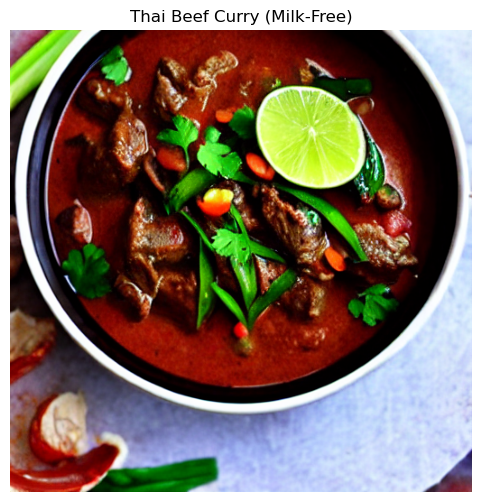

In [51]:
text = "Thai Beef Curry (Milk-Free)"
response = image_predictor.predict(text, {"ContentType": "application/x-text", "Accept": "application/json"})
display_image(response["generated_image"], text)

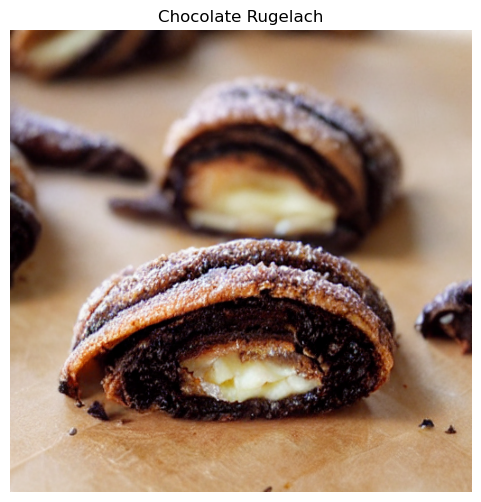

In [52]:
text = "Chocolate Rugelach"
response = image_predictor.predict(text, {"ContentType": "application/x-text", "Accept": "application/json"})
display_image(response["generated_image"], text)

Put the recipe + image together

In [71]:
def extract_title(recipe_text):
    lines = recipe_text.splitlines()
    title = ""
    title_found = False

    for line in lines:
        # find the title string
        if line.startswith("**Title:**"):
            title_found = True
            # Extract the title
            title = line.split("**Title:**")[1].strip()
        # Break if we reach the ingredients section
        elif line.startswith("**Ingredients:**") and title_found:
            break
    return title

{"inputs": "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful assistant that generates recipes in a well-structured format.\nPlease generate a recipe.\nEnsure that ingredients are listed only once and avoid repeating any entries.\nThe recipe should include the following sections:\n1. **Title** of the recipe\n2. **Ingredients List** with measurements (avoid repeats)\n3. **Instructions** in numbered steps for preparation\n\nReturn the result in the following format:\n\n**Title:**\nRecipe title here\n\n**Ingredients:**\n- Ingredient 1\n- Ingredient 2\n- Ingredient 3\n\n**Instructions:**\n1. Step 1\n2. Step 2\n3. Step 3\n\nMake sure the formatting follows the above structure exactly.\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nUse the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n#### Context ####\nAngel Food Cake with St

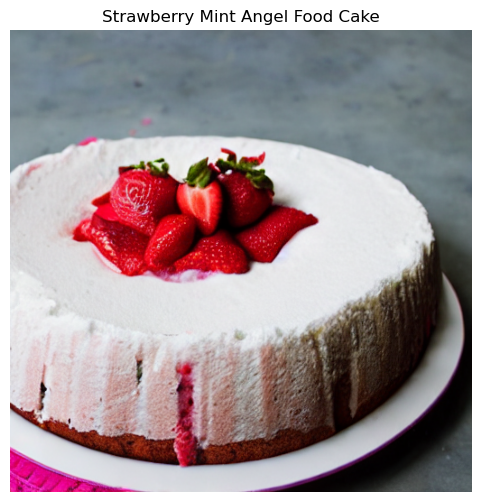

**Title:** Strawberry Mint Angel Food Cake

**Ingredients:**
- 1 store-bought angel food cake
- 16 ounces frozen strawberries, thawed and drained
- 1 tablespoon fresh mint leaves, finely chopped
- 1 tablespoon orange liqueur
- 8 ounces non-dairy whipped topping
- 1/4 teaspoon orange extract
- Fresh mint leaves, for garnish

**Instructions:**
1. Remove angel food cake from container and set on a plate.
2. Carefully remove the top of the cake by slicing horizontally 1/2-inch down from the top. Set top aside.
3. Hollow out the center of the cake.
4. Add the removed pieces of cake to a medium bowl.
5. Pick out 1 strawberry to use as garnish and set aside.
6. Add the remaining strawberries, chopped mint, orange liqueur, and 1/2 cup of the whipped topping to the bowl with the cake pieces. Fold until combined.
7. Fill cake, both the well and the center, with the strawberry mixture.
8. Replace the top of the cake that had been set aside.
9. Add a few drops of orange extract to the remaining wh

In [75]:
# Test the output
query = "I can't have milk or eggs. Is there a way to make a strawberry dessert without those ingredients?"
result = qa.invoke({"query": query})

recipe_text = result['result']
source_documents = result['source_documents']

# image generation
recipe_title = extract_title(recipe_text)
generated_image = generate_recipe_image(recipe_title)

display_image(generated_image, recipe_title)
print(recipe_text)

{"inputs": "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful assistant that generates recipes in a well-structured format.\nPlease generate a recipe.\nEnsure that ingredients are listed only once and avoid repeating any entries.\nThe recipe should include the following sections:\n1. **Title** of the recipe\n2. **Ingredients List** with measurements (avoid repeats)\n3. **Instructions** in numbered steps for preparation\n\nReturn the result in the following format:\n\n**Title:**\nRecipe title here\n\n**Ingredients:**\n- Ingredient 1\n- Ingredient 2\n- Ingredient 3\n\n**Instructions:**\n1. Step 1\n2. Step 2\n3. Step 3\n\nMake sure the formatting follows the above structure exactly.\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nUse the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n#### Context ####\nVegetable Curry with Fr

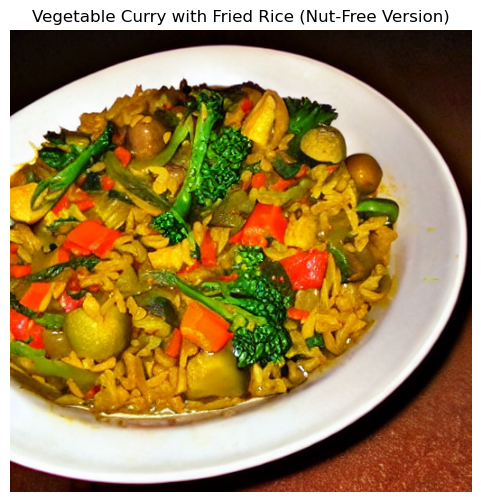

**Title:** Vegetable Curry with Fried Rice (Nut-Free Version)

**Ingredients:**

- 12 shallots, chopped
- 2 tablespoons chopped garlic
- 2 tablespoons chopped ginger
- 1 tablespoon turmeric powder or 2-inches fresh turmeric root, peeled
- 1/2 cup vegetable stock
- 1 cup coconut milk
- 1 cup cauliflower florets, blanched in salted water and cooled in an ice bath
- 1 cup mixed yellow and green patty pan squash, halved, blanched in salted water and cooled in an ice bath
- 2 cups mixed yellow and green squash, cut into 2-inch chunks and blanched in salted water and cooled in an ice bath
- 1 cup haricot verts, snipped and blanched in salted water and cooled in an ice bath
- 2 chayotes, cut into 2-inch chunks and blanched in salted water and cooled in an ice bath
- Grapeseed oil, to cook
- Salt and pepper
- Nasi Goreng, recipe follows
- Fried Shallots, recipe follows
- Peanut oil, for cooking

**Instructions:**

1. Preheat a fryer or deep pot of oil to 350 degrees F.
2. In a large pan, heat 

In [77]:
# Test the output
query = "I have a nut allergy. Can you make me a Thai curry dish without nuts and treenuts?"
result = qa.invoke({"query": query})

recipe_text = result['result']
source_documents = result['source_documents']

# image generation
recipe_title = extract_title(recipe_text)
generated_image = generate_recipe_image(recipe_title)

display_image(generated_image, recipe_title)
print(recipe_text)

{"inputs": "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful assistant that generates recipes in a well-structured format.\nPlease generate a recipe.\nEnsure that ingredients are listed only once and avoid repeating any entries.\nThe recipe should include the following sections:\n1. **Title** of the recipe\n2. **Ingredients List** with measurements (avoid repeats)\n3. **Instructions** in numbered steps for preparation\n\nReturn the result in the following format:\n\n**Title:**\nRecipe title here\n\n**Ingredients:**\n- Ingredient 1\n- Ingredient 2\n- Ingredient 3\n\n**Instructions:**\n1. Step 1\n2. Step 2\n3. Step 3\n\nMake sure the formatting follows the above structure exactly.\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\nUse the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n#### Context ####\nChicken Parmesan with p

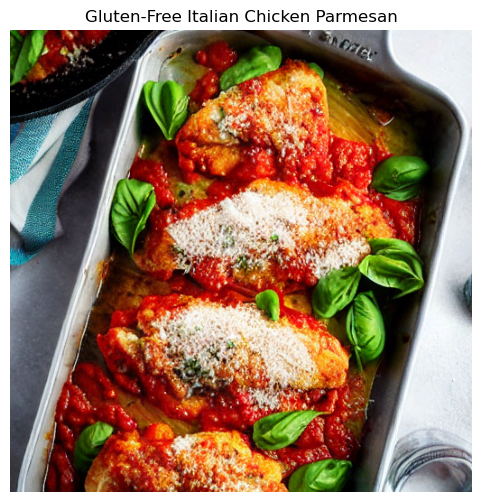

**Title:** Gluten-Free Italian Chicken Parmesan

**Ingredients:**
- 4 boneless, skinless chicken breast halves
- 1 cup gluten-free breadcrumbs
- 1 cup grated Parmesan cheese
- 1 cup tomato sauce (make sure it's gluten-free)
- 1 egg
- 1 cup shredded mozzarella cheese
- Salt and pepper to taste
- Olive oil for frying
- Fresh basil leaves for garnish

**Instructions:**
1. Preheat the oven to 375°F (190°C).
2. Prepare the chicken breasts by seasoning with salt and pepper.
3. Dip each chicken breast in the beaten egg and then coat with gluten-free breadcrumbs.
4. Heat olive oil in a large skillet over medium-high heat. Fry the breaded chicken breasts until golden brown on both sides.
5. Transfer the fried chicken to a baking dish and top each breast with tomato sauce and shredded mozzarella cheese.
6. Bake in the preheated oven for 20-25 minutes or until the cheese is melted and bubbly.
7. Garnish with fresh basil leaves and serve hot.

Note: Make sure to choose a gluten-free breadcrumb opt

In [78]:
# Test the output
query = "I'm allergic to gluten. Could you create an Italian chicken parmesan recipe that's gluten-free?"
result = qa.invoke({"query": query})

recipe_text = result['result']
source_documents = result['source_documents']

# image generation
recipe_title = extract_title(recipe_text)
generated_image = generate_recipe_image(recipe_title)

display_image(generated_image, recipe_title)
print(recipe_text)